**Исследование удовлетворённости потребителей на основе анализа текстовых отзывов**

---



# *Скачиваем нужные библиотеки и данные*

In [ ]:
import pandas as pd
import warnings
import numpy as np
from zipfile import ZipFile
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
# import requests
# import bs4
# import codecs
import nltk
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
import joblib
import math
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error

In [ ]:
!pip install pymorphy2

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import re, string, unicodedata
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import pymorphy2
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay
import plotly.graph_objs as go
import plotly.offline as py

In [ ]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"ivanchuhonin","key":""}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
!kaggle datasets download -d kyakovlev/yandex-geo-reviews-dataset-2023
!unzip -q kyakovlev/yandex-geo-reviews-dataset-2023.zip
zf = ZipFile('/content/yandex-geo-reviews-dataset-2023.zip', 'r')
zf.extractall('/content/yandex-geo-reviews-dataset-2023.csv')

In [ ]:
df = pd.read_csv('/content/yandex-geo-reviews-dataset-2023.csv/geo-reviews-dataset-2023.csv')
df = df[df['rating']>0]

In [ ]:
mapping = {
    5: "Отлично",
    4: "Хорошо",
    3: "Удовлетворительно",
    2: "Неудовлетворительно",
    1: "Плохо"}

df['Оценка'] = df['rating'].map(mapping)
df.head()

address             name_ru  \
0  Екатеринбург, ул. Московская / ул. Волгоградск...  Московский квартал   
1  Московская область, Электросталь, проспект Лен...   Продукты Ермолино   
2  Краснодар, Прикубанский внутригородской округ,...             LimeFit   
3   Санкт-Петербург, проспект Энгельса, 111, корп. 1        Snow-Express   
4                  Тверь, Волоколамский проспект, 39  Студия Beauty Brow   

   rating                                            rubrics  \
0     3.0                                     Жилой комплекс   
1     5.0  Магазин продуктов;Продукты глубокой заморозки;...   
2     1.0                                        Фитнес-клуб   
3     4.0        Пункт проката;Прокат велосипедов;Сапсёрфинг   
4     5.0  Салон красоты;Визажисты, стилисты;Салон бровей...   

                                                text             Оценка  
0  Московский квартал 2.\nШумно : летом по ночам ...  Удовлетворительно  
1  Замечательная сеть магазинов в общем, хороший ...            Отлично  
2  Не знаю смутят ли кого-то данные правила, но я...              Плохо  
3  Хорошие условия аренды. \nДружелюбный персонал...             Хорошо  
4  Топ мастер Ангелина топ во всех смыслах ) Немн...            Отлично

In [ ]:
part_df = df # .sample(frac = 0.8)
# part_df.head()

# Исследование данных и визуализация

In [ ]:
# df_spb = df[df['address'].str.contains('Санкт-Петербург')]

In [ ]:
df_rubric = df.copy()
df_rubric.explode('rubrics')
df_rubric['rubrics'] = df_rubric['rubrics'].apply(lambda x: x.split(',')[0])
df_rubric['rubrics'] = df_rubric['rubrics'].apply(lambda x: x.split(';')[0])

In [ ]:
# part_df = part_df.drop(columns=['address', 'name_ru', 'rubrics'])
df_rub = df_rubric[df_rubric['rubrics'].str.contains('Ресторан|Кафе')]

In [ ]:
part_df = df_rub

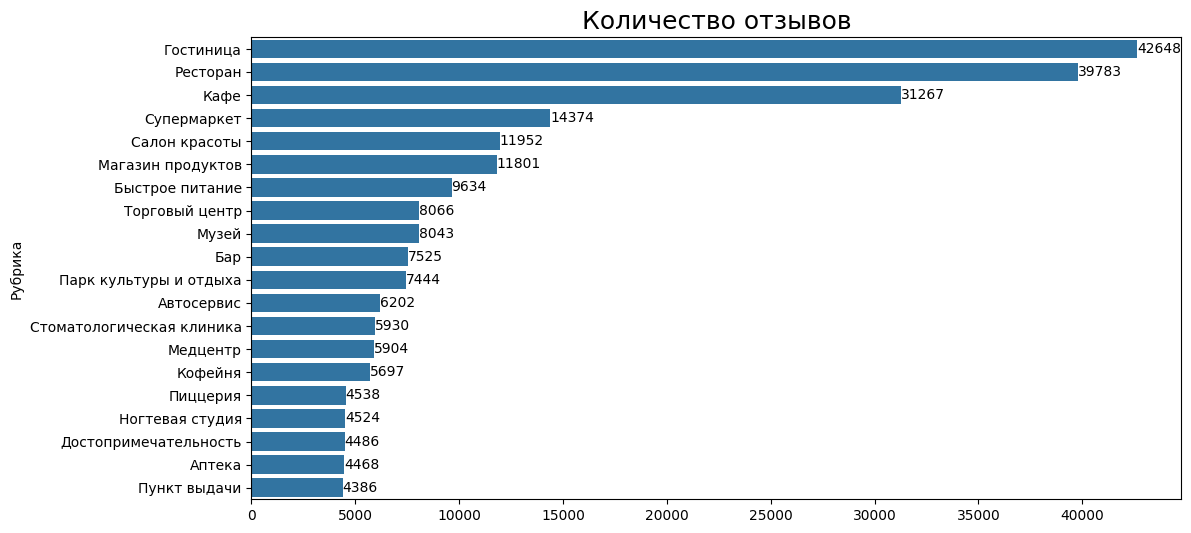

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data = df_rubric, y = 'rubrics',
                   order = df_rubric.rubrics.value_counts().nlargest(20).index)
ax.bar_label(ax.containers[0])
ax.set_title('Количество отзывов', fontsize=18)
plt.xlabel(None)
plt.ylabel('Рубрика')
plt.show()

In [ ]:
trace0 = go.Bar(
            x = df[df["rating"]== 5]["rating"].value_counts().index.values,
            y = df[df["rating"]== 5]["rating"].value_counts().values,
            name='Позитивный фидбек')
trace1 = go.Bar(
            x = df.query('rating == 4 or rating == 3')["rating"].value_counts().index.values,
            y = df.query('rating == 4 or rating == 3')["rating"].value_counts().values,
            name='Нейтральный фидбек')
trace2 = go.Bar(
            x = df[df["rating"] < 3]["rating"].value_counts().index.values,
            y = df[df["rating"] < 3]["rating"].value_counts().values,
            name='Негативный фидбек')
data = [trace0, trace1, trace2]
layout = go.Layout(yaxis=dict(title='Количество'),
                   xaxis=dict(title='Оценки'), title='Распределение фидбека')

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
fig.data[2].marker.line.width = 4
fig.data[2].marker.line.color = "black"
fig.data[0].marker.color = "green"
fig.data[1].marker.color = "blue"
fig.data[2].marker.color = "red"
py.iplot(fig)

In [ ]:
parameter_list = ['rubrics', 'rating']
def creating_hist_and_pie(parameter_list):
    fig, axes = plt.subplots(nrows=len(parameter_list), ncols=2, figsize=(16, 8))

    for i, parameter in enumerate(parameter_list):
        for j in range(2):
            ax = axes[i, j] if len(parameter_list) > 1 else axes[j]
            if j == 0:
                top_20_values = df_rubric[parameter].value_counts().nlargest(20)
                top_20_values.plot(kind='bar', ax=ax, color='forestgreen')
                ax.set_xlabel(parameter)
                ax.set_ylabel('Количество')
                ax.set_title(f'Гистограмма {parameter}')
            else:
                parameter_counts = df_rubric[parameter].value_counts()
                # Calculate the percentage for each value in the parameter_counts
                percentages = parameter_counts / parameter_counts.sum() * 100
                # Get the values that account for less than 6%
                other_values = percentages[percentages < 1.9]
                # Combine the other_values into a single category
                other_values_sum = other_values.sum()
                parameter_counts = parameter_counts[~parameter_counts.index.isin(other_values.index)]
                # Check if the percentage for the "Other" category is greater than 0
                if other_values_sum > 0:
                    parameter_counts['Прочее'] = other_values_sum
                # Plot the pie chart if there are categories to display
                if len(parameter_counts) > 0:
                    ax.pie(parameter_counts, labels=parameter_counts.index, autopct='%1.1f%%')
                    ax.set_title(f'Круговая диаграмма {parameter}')
    plt.tight_layout()
    plt.show()

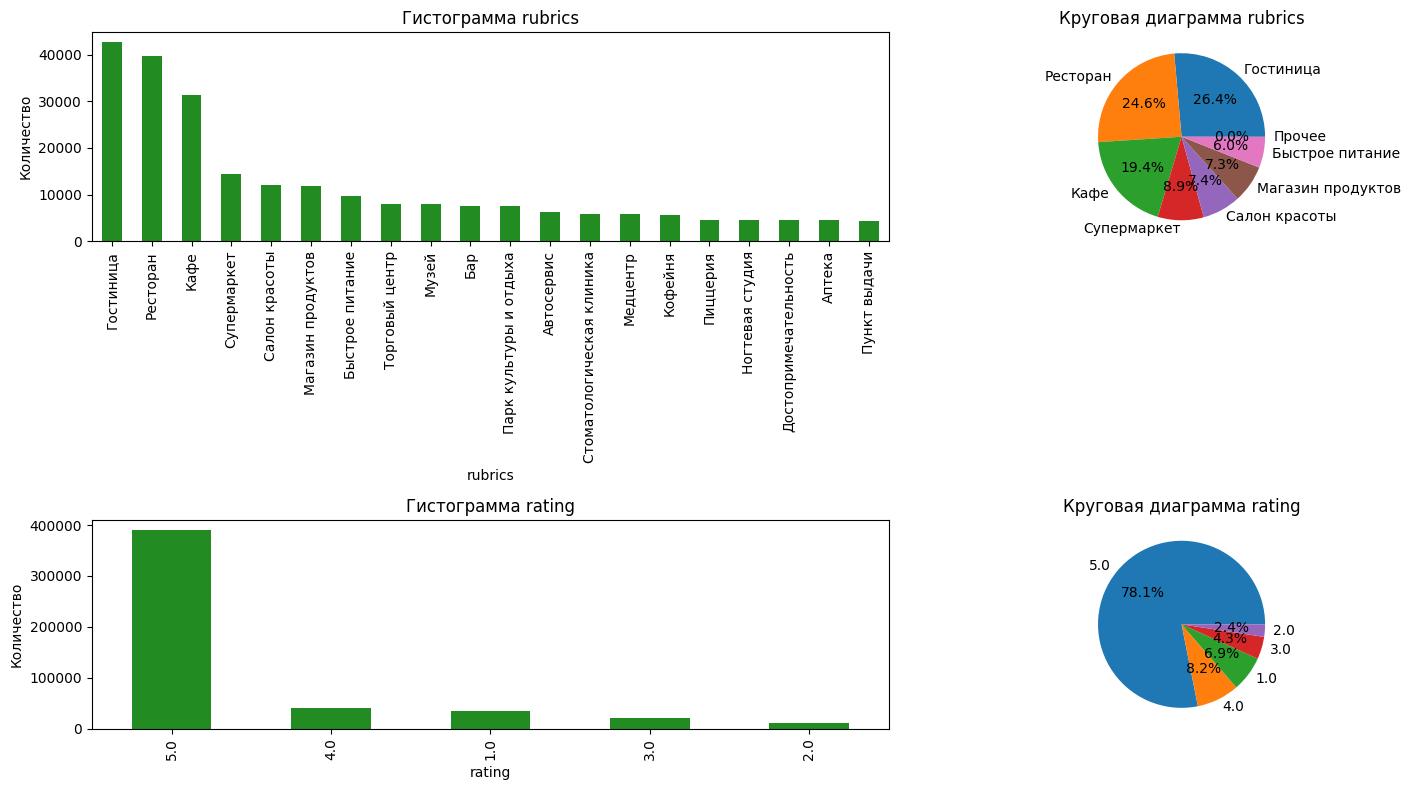

In [ ]:
creating_hist_and_pie(parameter_list)

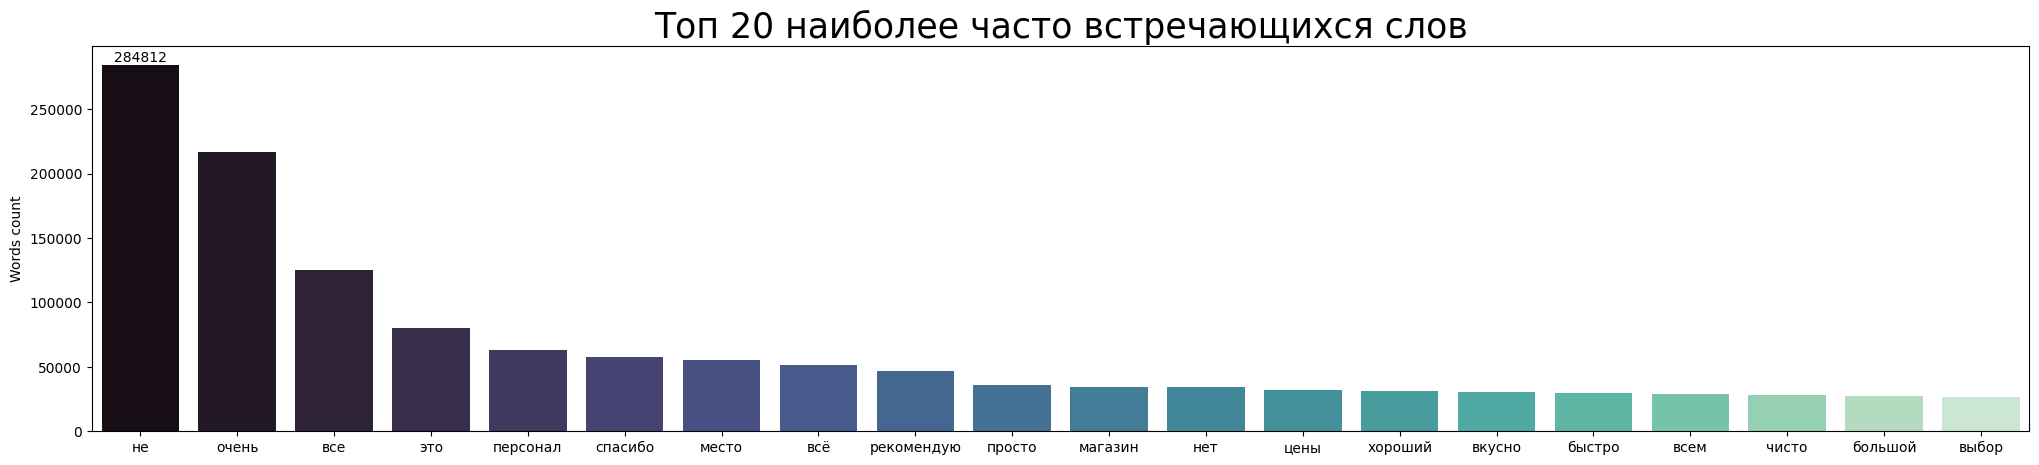

In [ ]:
plt.figure(figsize=(25, 5))
ax = sns.barplot(x=keys, y=values, palette='mako', hue=keys)
plt.title('Топ 20 наиболее часто встречающихся слов', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

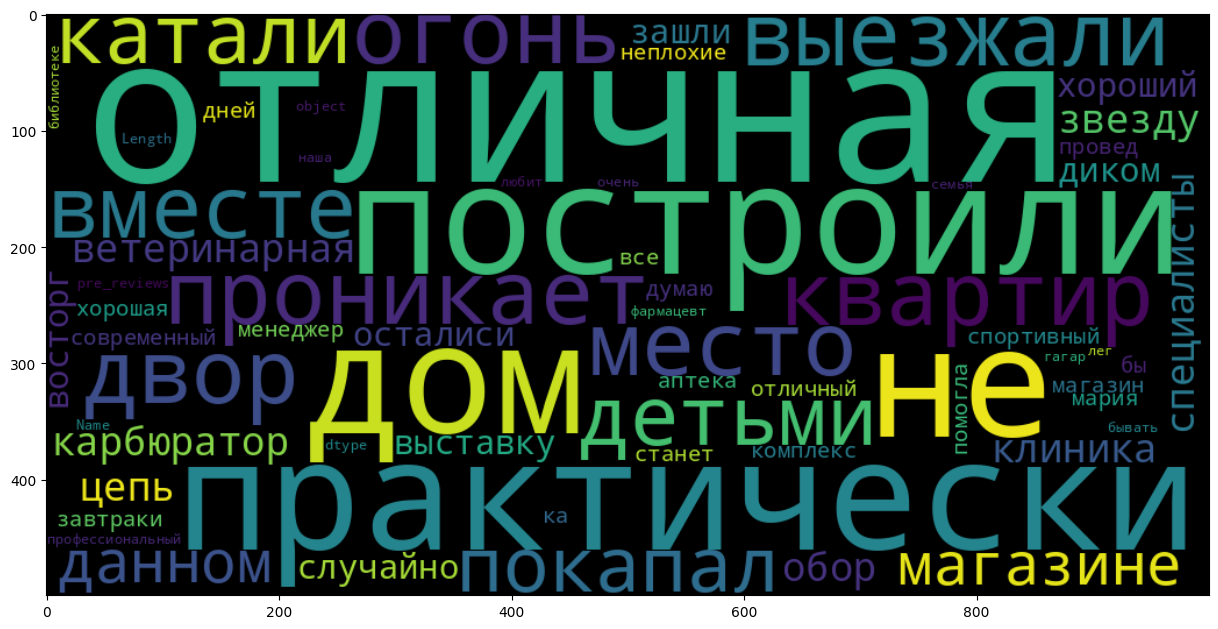

In [ ]:
plt.figure(figsize=(15,15))
positive_text= test_df.pre_reviews
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(str(positive_text))
plt.imshow(positive_words,interpolation='bilinear')

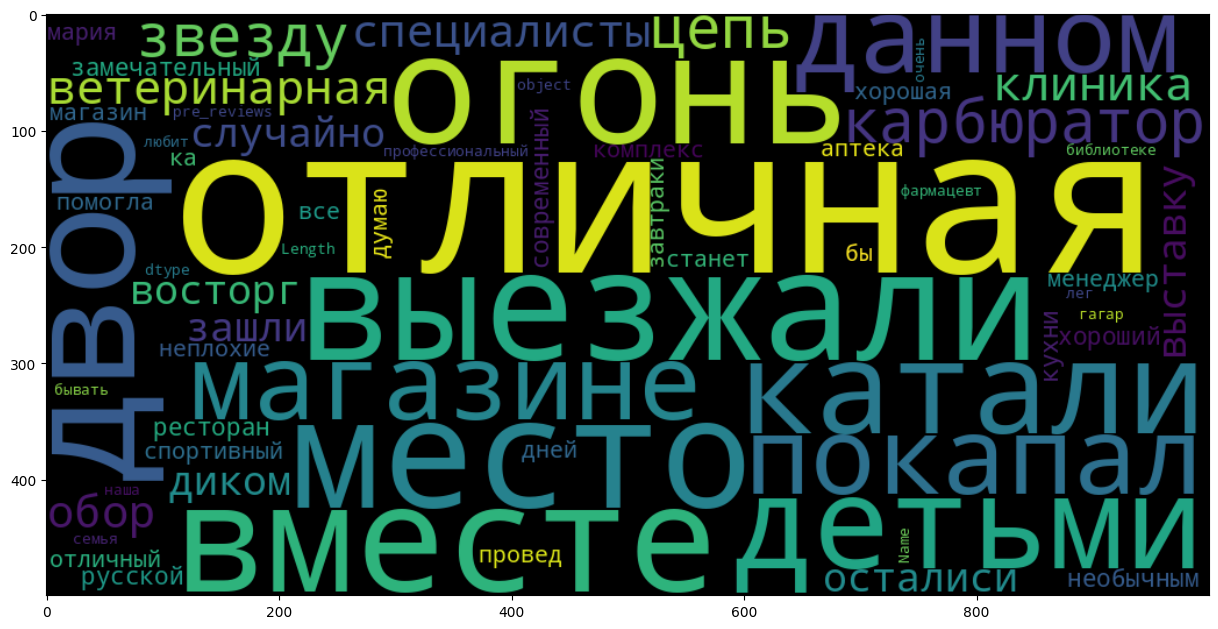

In [ ]:
plt.figure(figsize=(15,15))
positive_text = test_df[test_df['Оценка']=='Отлично']['pre_reviews']
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(str(positive_text))
plt.imshow(positive_words,interpolation='bilinear')

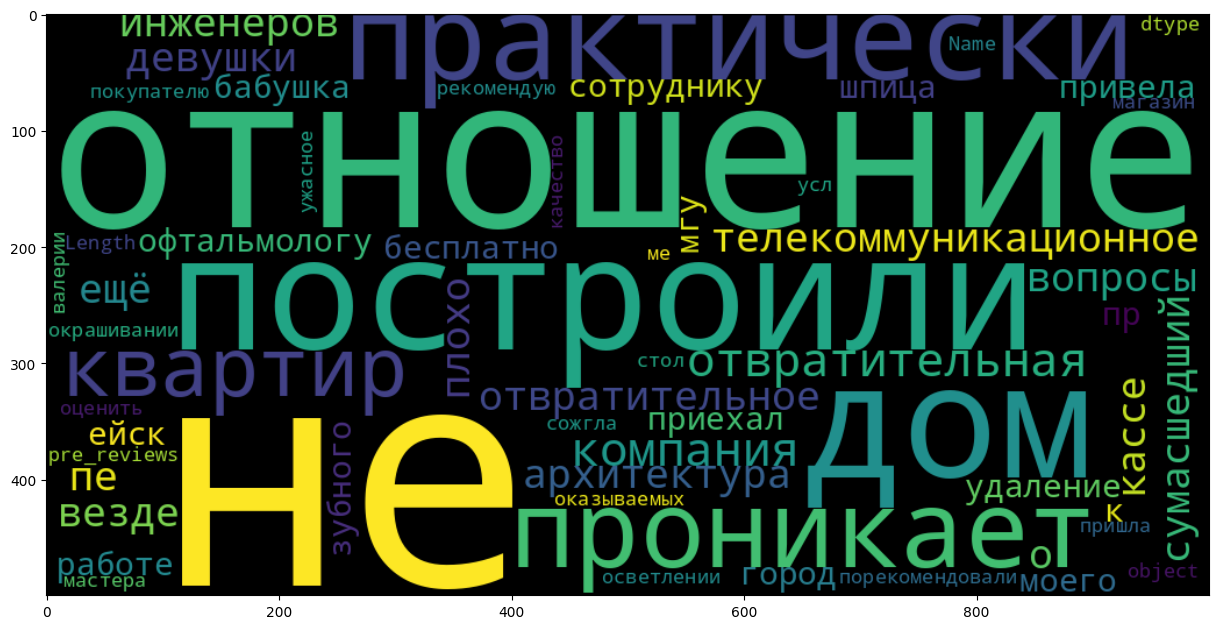

In [ ]:
plt.figure(figsize=(15,15))
positive_text = test_df[test_df['Оценка']=='Плохо']['pre_reviews']
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(str(positive_text))
plt.imshow(positive_words,interpolation='bilinear')

# Анализ удовлетворённости

In [ ]:
part_df['city'] = part_df['address'].str.split(', ').str.get(0).str.strip()
part_df['section'] = part_df['rubrics'].str.split(', ').str.get(0).str.strip()
part_df['section'] = part_df['section'].str.split(';').str.get(0).str.strip()
# part_df.head(5)

In [ ]:
big_cities = ['Москва', 'Санкт-Петербург', 'Новосибирск', 'Воронеж', 'Республика Татарстан', 'Самара', 'Краснодар',
              'Республика Башкортостан', 'Нижний Новгород', 'Красноярск', 'Волгоград', 'Пермь'] # Уфа Казань Омск
fast_food = ['KFC', 'Вкусно — и точка', 'Бургер Кинг']
marketplace = ['Ozon', 'Wildberries', 'Яндекс Маркет']
shops = ["Магнит", "О'кей", "Перекрёсток", "Пятёрочка", "Ашан"] # Дикси

In [ ]:
big_cities_df = part_df[part_df['city'].isin(big_cities)]

In [ ]:
big_cities_fast_food = big_cities_df[big_cities_df['name_ru'].isin(fast_food)]
mean_rate_fast_food = big_cities_fast_food.groupby(['city', 'name_ru'])['rating'].mean().reset_index()
mean_rate_fast_food.head()

In [ ]:
big_cities_market_place = big_cities_df[big_cities_df['name_ru'].isin(marketplace)]
mean_rate_market_place = big_cities_market_place.groupby(['city', 'name_ru'])['rating'].mean().reset_index()
mean_rate_market_place.head()

In [ ]:
big_cities_shops = big_cities_df[big_cities_df['name_ru'].isin(shops)]
mean_rate_shops = big_cities_shops.groupby(['city', 'name_ru'])['rating'].mean().reset_index()
mean_rate_shops.head()

**Удовлетворённость пользователей маркетплейсов в крупнейших городах**

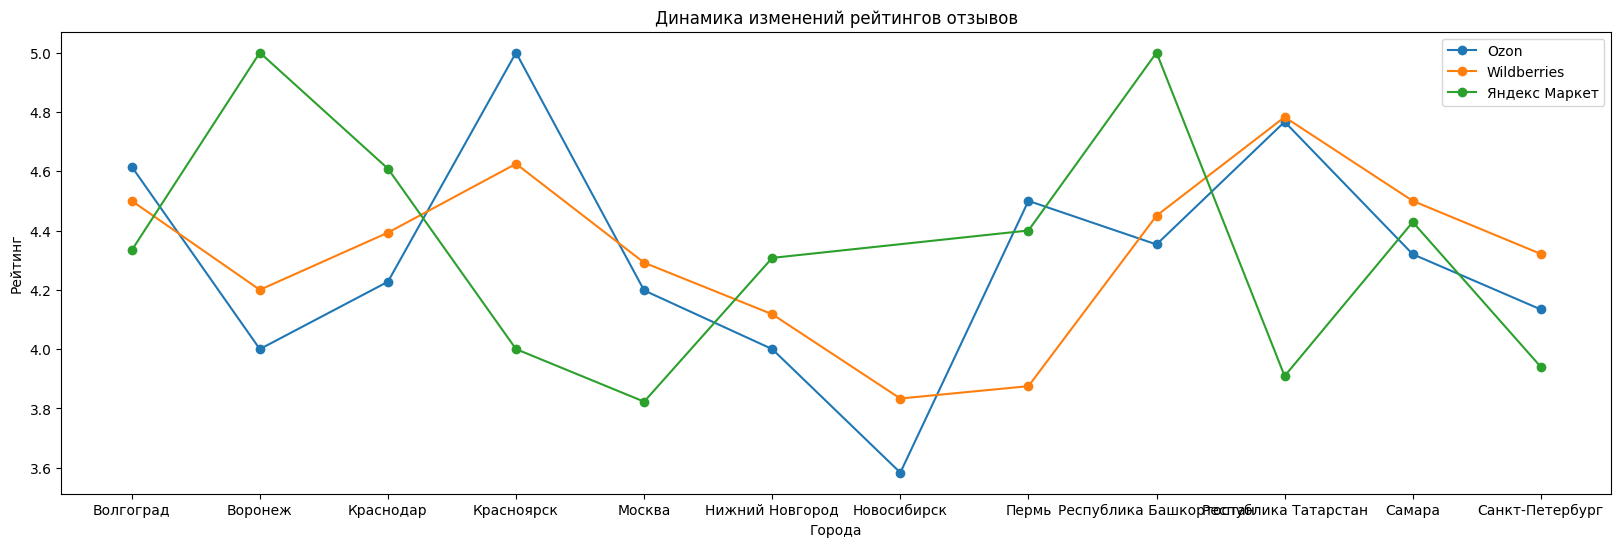

In [ ]:
plt.figure(figsize=(20, 6))
for company in marketplace:
    company_sales = mean_rate_market_place[mean_rate_market_place['name_ru'] == company].groupby('city')['rating'].sum()
    plt.plot(company_sales.index, company_sales, marker='o', label=company)
plt.xlabel('Города')
plt.ylabel('Рейтинг')
plt.title('Динамика изменений рейтингов отзывов')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

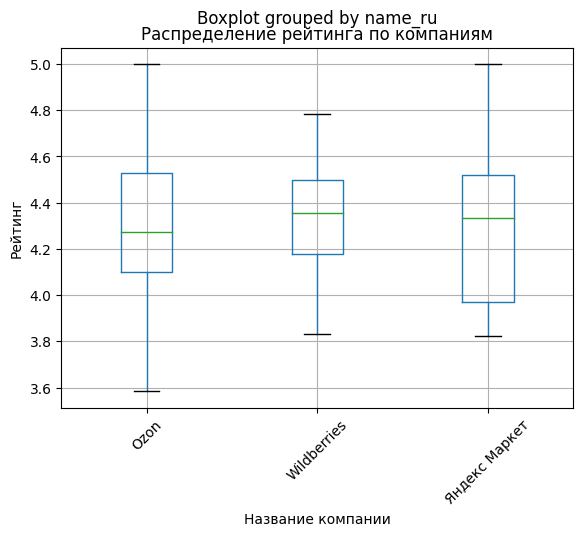

In [ ]:
plt.figure(figsize=(10, 6))
mean_rate_market_place.boxplot(column='rating', by='name_ru')
plt.xlabel('Название компании')
plt.ylabel('Рейтинг')
plt.title('Распределение рейтинга по компаниям')
plt.xticks(rotation=45)
plt.show()

**Удовлетворённость потребителей фастфуда в крупнейших городах**

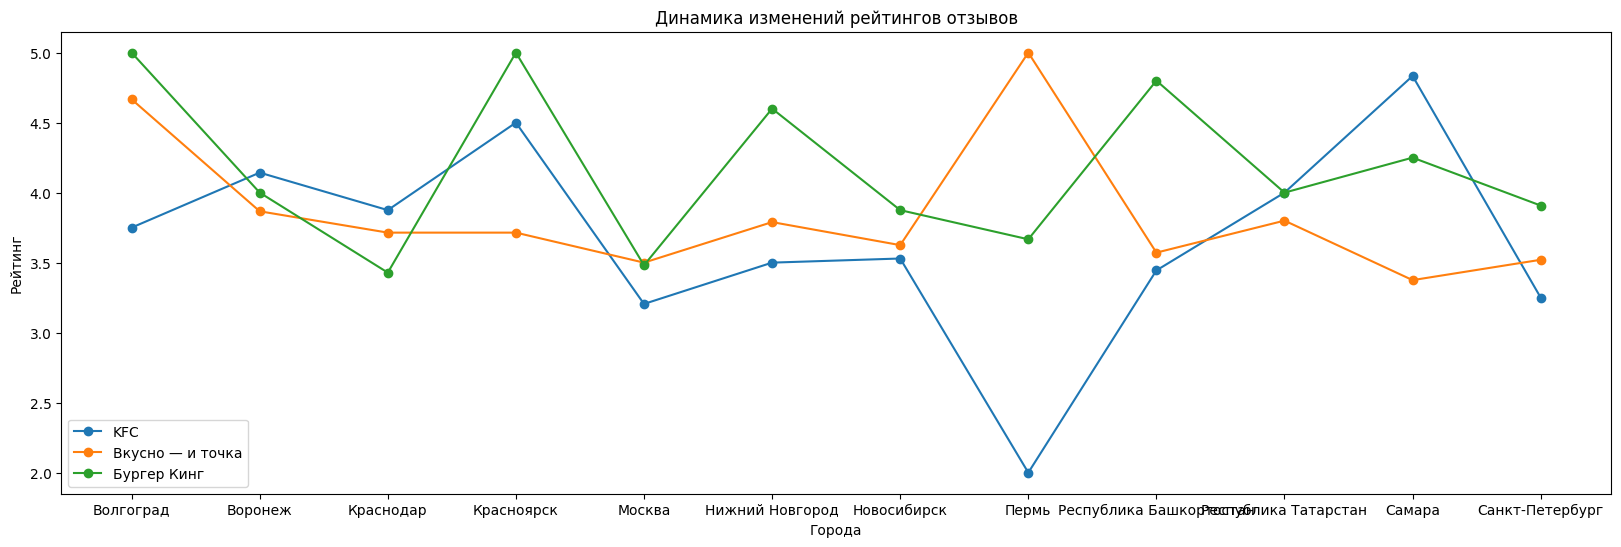

In [ ]:
plt.figure(figsize=(20, 6))
for company in fast_food:
    company_sales = mean_rate_fast_food[mean_rate_fast_food['name_ru'] == company].groupby('city')['rating'].sum()
    plt.plot(company_sales.index, company_sales, marker='o', label=company)
plt.xlabel('Города')
plt.ylabel('Рейтинг')
plt.title('Динамика изменений рейтингов отзывов')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

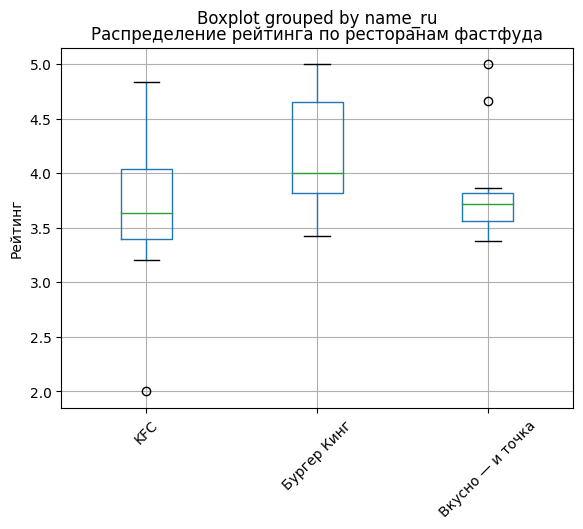

In [ ]:
plt.figure(figsize=(10, 6))
mean_rate_fast_food.boxplot(column='rating', by='name_ru')
plt.xlabel('')
plt.ylabel('Рейтинг')
plt.title('Распределение рейтинга по ресторанам фастфуда')
plt.xticks(rotation=45)
plt.show()

**Удовлетворённость посетителей супермаркетов в крупнейших городах**

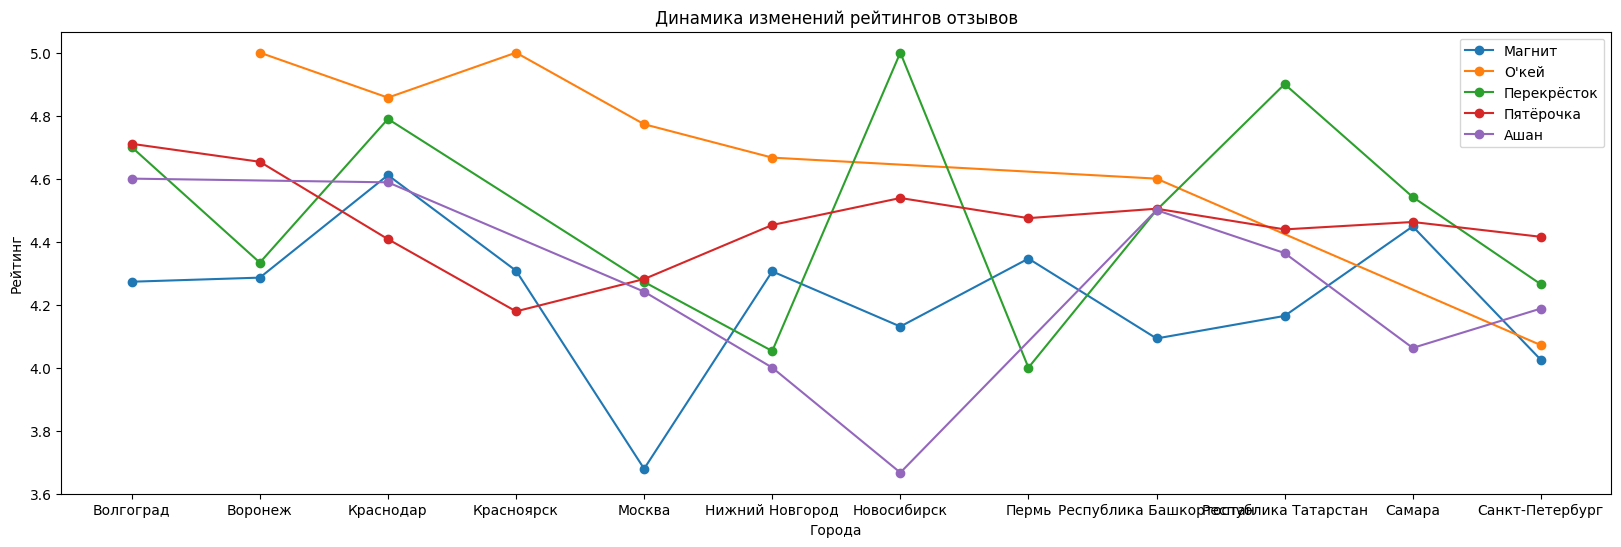

In [ ]:
plt.figure(figsize=(20, 6))
for company in shops:
    company_sales = mean_rate_shops[mean_rate_shops['name_ru'] == company].groupby('city')['rating'].sum()
    plt.plot(company_sales.index, company_sales, marker='o', label=company)
plt.xlabel('Города')
plt.ylabel('Рейтинг')
plt.title('Динамика изменений рейтингов отзывов')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

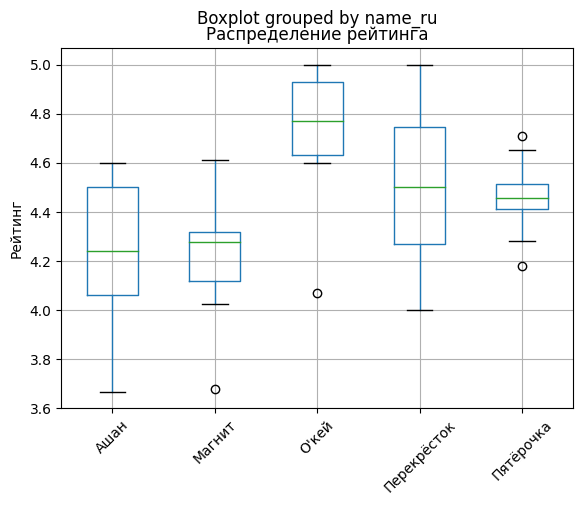

In [ ]:
plt.figure(figsize=(10, 6))
mean_rate_shops.boxplot(column='rating', by='name_ru')
plt.xlabel('')
plt.ylabel('Рейтинг')
plt.title('Распределение рейтинга')
plt.xticks(rotation=45)
plt.show()

# Предобработка отзывов

Предобработка отзывов включаетв себя: удаление пунктуации и других спец. символов, удаление стоп слов и лишних пробелов, а также лемматизацию.

In [ ]:
def preprocess(text, remove_stopwords=True):
    text = re.sub("[^а-яА-ЯёЁ]"," ", str(text))
    text = re.sub("[\n]"," ", text)
    return text

In [ ]:
part_df['pre_text'] = part_df['text'].apply(preprocess)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

words_to_remove = ["нет", "не", "ни", "всё", "все"]
stop_words -= set(words_to_remove)
words_to_add = ["'", "''", '""', '"', "<", ">", "?", ")",
                "(", ".", "!", ",", ":", "-", "%", "$", "^", "@", "[",
                "]", "{", "}", "/", "\\", "_", "&", "№", "~",
                "`", "``", "''", '""', '1.', "2.", "3.", "4.",
                "5.", "6.", "7.", "8.", "9."]  #
stop_words.update(words_to_add)
analyzer = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenize_text(text):
    if pd.notnull(text):
        words = word_tokenize(text)
        return words
    else:
        return []

def lowercase_text(text):
    if pd.notnull(text):
        lowercase_text = text.lower()
        return lowercase_text
    else:
        return text

def remove_stopwords(text):
    if pd.notnull(text):
        words = word_tokenize(text, language='russian')
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_text = ' '.join(filtered_words)
        return filtered_text
    else:
        return text

def text_to_wordlist(text):
    norm_words = [analyzer.parse(word)[0].normal_form for word in text]
    return norm_words

test_df = part_df.copy()

test_df['pre_test'] = test_df['pre_text'].apply(lowercase_text).apply(remove_stopwords).apply(tokenize_text) # .apply(text_to_wordlist)

In [ ]:
test_df['reviews'] = test_df['pre_test'].apply(lambda x: ', '.join(map(str, x)))
test_df.head()

address             name_ru  \
0  Екатеринбург, ул. Московская / ул. Волгоградск...  Московский квартал   
1  Московская область, Электросталь, проспект Лен...   Продукты Ермолино   
2  Краснодар, Прикубанский внутригородской округ,...             LimeFit   
3   Санкт-Петербург, проспект Энгельса, 111, корп. 1        Snow-Express   
4                  Тверь, Волоколамский проспект, 39  Студия Beauty Brow   

   rating                                            rubrics  \
0     3.0                                     Жилой комплекс   
1     5.0  Магазин продуктов;Продукты глубокой заморозки;...   
2     1.0                                        Фитнес-клуб   
3     4.0        Пункт проката;Прокат велосипедов;Сапсёрфинг   
4     5.0  Салон красоты;Визажисты, стилисты;Салон бровей...   

                                                text             Оценка  \
0  Московский квартал 2.\nШумно : летом по ночам ...  Удовлетворительно   
1  Замечательная сеть магазинов в общем, хороший ...            Отлично   
2  Не знаю смутят ли кого-то данные правила, но я...              Плохо   
3  Хорошие условия аренды. \nДружелюбный персонал...             Хорошо   
4  Топ мастер Ангелина топ во всех смыслах ) Немн...            Отлично   

                                            pre_text  \
0  Московский квартал     Шумно   летом по ночам ...   
1  Замечательная сеть магазинов в общем  хороший ...   
2  Не знаю смутят ли кого то данные правила  но я...   
3  Хорошие условия аренды    Дружелюбный персонал...   
4  Топ мастер Ангелина топ во всех смыслах   Немн...   

                                            pre_test  \
0  [московский, квартал, шумно, летом, ночам, дик...   
1  [замечательная, сеть, магазинов, общем, хороши...   
2  [не, знаю, смутят, кого, данные, правила, удив...   
3  [хорошие, условия, аренды, дружелюбный, персон...   
4  [топ, мастер, ангелина, топ, смыслах, немного,...   

                                             reviews  
0  московский, квартал, шумно, летом, ночам, дики...  
1  замечательная, сеть, магазинов, общем, хороший...  
2  не, знаю, смутят, кого, данные, правила, удивл...  
3  хорошие, условия, аренды, дружелюбный, персона...  
4  топ, мастер, ангелина, топ, смыслах, немного, ...

In [ ]:
def preprocess2(text, remove_stopwords=True):
    text = re.sub(", "," ", text)
    return text

In [ ]:
test_df['pre_reviews'] = test_df['reviews'].apply(preprocess2)

# TfidfVectorizer frequency

In [ ]:
# tf_df = test_df[['rating', 'text', 'pre_reviews']]
tf_df = test_df[['rating', 'text', 'reviews']]
tf_df.head()

rating                                               text  \
0     3.0  Московский квартал 2.\nШумно : летом по ночам ...   
1     5.0  Замечательная сеть магазинов в общем, хороший ...   
2     1.0  Не знаю смутят ли кого-то данные правила, но я...   
3     4.0  Хорошие условия аренды. \nДружелюбный персонал...   
4     5.0  Топ мастер Ангелина топ во всех смыслах ) Немн...   

                                             reviews  
0  московский, квартал, шумно, лето, ночь, дикий,...  
1  замечательный, сеть, магазин, общий, хороший, ...  
2  не, знать, смутить, кто, дать, правило, удивит...  
3  хороший, условие, аренда, дружелюбный, персона...  
4  топ, мастер, ангелина, топ, смысл, немного, во...

In [ ]:
train, test = train_test_split(tf_df,
                        test_size = 0.2,
                        random_state = 40)

In [ ]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1))
count_idf_neutral = TfidfVectorizer(ngram_range = (1,1))

tf_idf_positive = count_idf_positive.fit_transform(train.query('rating == 5')['reviews'])
tf_idf_neutral = count_idf_neutral.fit_transform(train.query('rating == 4 or rating == 3')['reviews'])
tf_idf_negative = count_idf_negative.fit_transform(train.query('rating < 3')['reviews'])

In [ ]:
pos_frequence = pd.DataFrame(
  {'word' : count_idf_positive.get_feature_names_out(),
  'frequency' : np.array(tf_idf_positive.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

neu_frequence = pd.DataFrame(
  {'word' : count_idf_neutral.get_feature_names_out(),
  'frequency' : np.array(tf_idf_neutral.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

neg_frequence = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'frequency' : np.array(tf_idf_negative.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

neg_frequence_filtered = neg_frequence\
							.query('word not in @pos_frequence.word and word not in @neu_frequence.word')[:100]

neu_frequence_filtered = neu_frequence\
							.query('word not in @pos_frequence.word and word not in @neg_frequence.word')[:100]

pos_frequence_filtered = pos_frequence\
							.query('word not in @neg_frequence.word and word not in @neu_frequence.word')[:100]

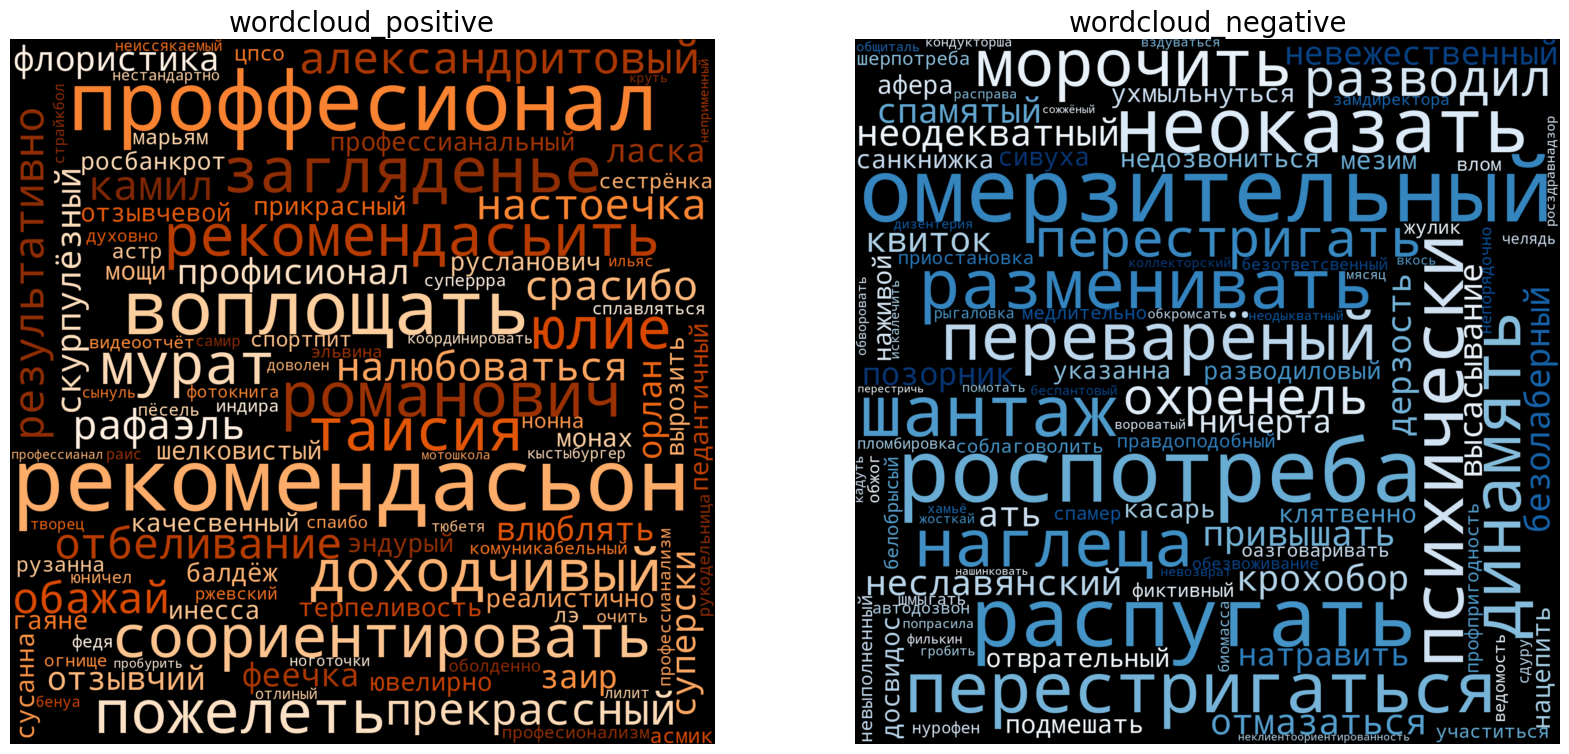

In [ ]:
wordcloud_neg = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None,
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(neg_frequence_filtered.values))

wordcloud_neu = WordCloud(background_color="black",
                               colormap = 'Greens',
                               max_words=200,
                               mask=None,
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(neu_frequence_filtered.values))

wordcloud_pos = WordCloud(background_color="black",
                               colormap = 'Oranges',
                               max_words=200,
                               mask=None,
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(pos_frequence_filtered.values))
fig, ax = plt.subplots(1, 2, figsize = (20, 20))

ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[0].set_title('wordcloud_positive', fontsize = 20)
ax[1].set_title('wordcloud_negative', fontsize = 20)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

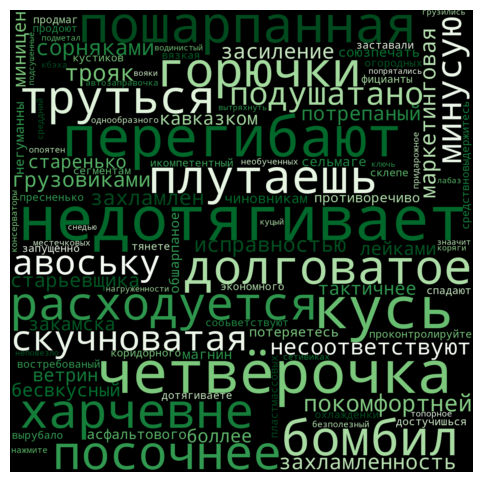

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.imshow(wordcloud_neu, interpolation='bilinear')
# ax.set_title('wordcloud_neutral', fontsize = 20)
ax.axis("off")
plt.show()

# Частотные слова на примерах из рубрики ресторанное дело

In [ ]:
test_df = test_df.dropna(subset=['name_ru'])
rest_df = test_df[test_df['address'].str.contains('Санкт-Петербург')]
rest_df2 = rest_df.groupby('name_ru').size().reset_index(name='counts')

In [ ]:
rest_df2.sort_values(by='counts', ascending=False)[:10]

name_ru  counts
8403                Евразия     421
14394            ТОКИО-CITY     373
12718             Пятёрочка     301
12055           Перекрёсток     170
10322             Мама Рома     162
10256                Магнит     162
6512   Булочная Ф. Вольчека     162
3405                   Ozon     158
15979               Шаверно     150
8131                  Дикси     148

In [ ]:
df_rest_exm = rest_df[rest_df['name_ru'].str.contains('ТОКИО-CITY')]
df_rest_exm.head()

In [ ]:
tf_df = df_rest_exm[['rating', 'text', 'reviews']]
# tf_df.head()

In [ ]:
train, test = train_test_split(tf_df,
                        test_size = 0.2,
                        random_state = 40)

In [ ]:
count_idf_positive = TfidfVectorizer(ngram_range = (1,1))
count_idf_negative = TfidfVectorizer(ngram_range = (1,1))
count_idf_neutral = TfidfVectorizer(ngram_range = (1,1))

# tf_idf_positive = count_idf_positive.fit_transform(train.query('rating == 5')['reviews'])
tf_idf_positive = count_idf_positive.fit_transform(train.query('rating == 5 or rating == 4')['reviews'])
tf_idf_negative = count_idf_negative.fit_transform(train.query('rating < 4')['reviews'])

In [ ]:
pos_frequence = pd.DataFrame(
  {'word' : count_idf_positive.get_feature_names_out(),
  'frequency' : np.array(tf_idf_positive.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

#neu_frequence = pd.DataFrame(
  #{'word' : count_idf_neutral.get_feature_names_out(),
  #'frequency' : np.array(tf_idf_neutral.sum(axis = 0))[0]
    #}).sort_values(by = 'frequency', ascending = False)

neg_frequence = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'frequency' : np.array(tf_idf_negative.sum(axis = 0))[0]
    }).sort_values(by = 'frequency', ascending = False)

neg_frequence_filtered = neg_frequence\
							.query('word not in @pos_frequence.word and word not in @neu_frequence.word')[:100]

#neu_frequence_filtered = neu_frequence\
							#.query('word not in @pos_frequence.word and word not in @neg_frequence.word')[:100]

pos_frequence_filtered = pos_frequence\
							.query('word not in @neg_frequence.word and word not in @neu_frequence.word')[:100]

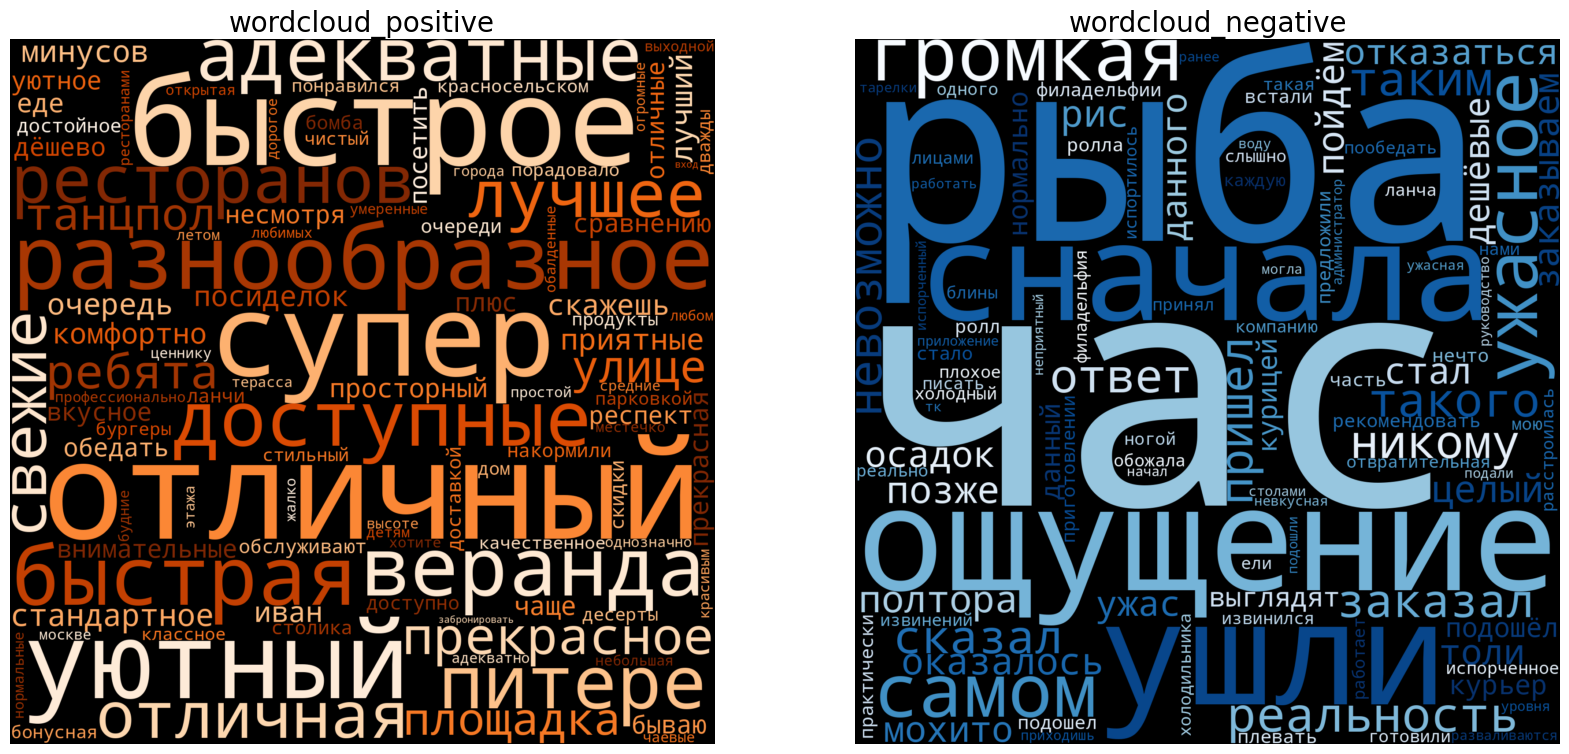

In [ ]:
wordcloud_neg = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None,
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(neg_frequence_filtered.values))

wordcloud_neu = WordCloud(background_color="black",
                               colormap = 'Greens',
                               max_words=200,
                               mask=None,
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(neg_frequence_filtered.values))

wordcloud_pos = WordCloud(background_color="black",
                               colormap = 'Oranges',
                               max_words=200,
                               mask=None,
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(pos_frequence_filtered.values))
fig, ax = plt.subplots(1, 2, figsize = (20, 20))

ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[0].set_title('wordcloud_positive', fontsize = 20)
ax[1].set_title('wordcloud_negative', fontsize = 20)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

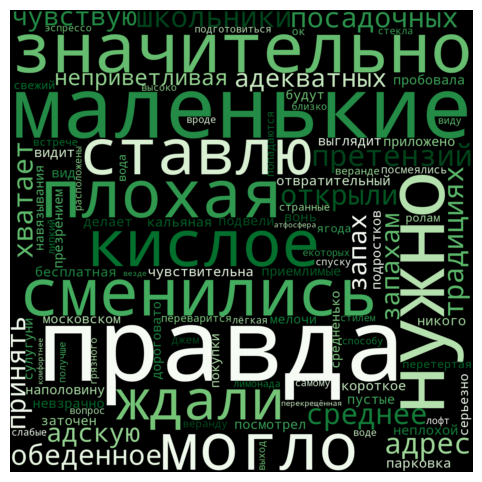

In [ ]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.imshow(wordcloud_neu, interpolation='bilinear')
# ax.set_title('wordcloud_neutral', fontsize = 20)
ax.axis("off")
plt.show()

# Bag-of-words + Random forest model

In [ ]:
X = test_df['reviews']
y = test_df['Оценка']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [ ]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

Обучаем модель

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=40)  # bootstrap= False, criterion= 'entropy'
rf_classifier.fit(X_train_bow, y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
accuracy = rf_classifier.score(X_test_bow, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8076430572228892


Применяем модель для определения тональности

In [ ]:
new_review = ["Этот продукт просто потрясающий! Очень доволен покупкой."]
new_review_bow = vectorizer.transform(new_review)
prediction = rf_classifier.predict(new_review_bow)

if prediction[0] == 'Отлично':
    print("Положительный отзыв!")
else:
    print("Отрицательный отзыв.")

Положительный отзыв!


In [ ]:
new_review = ["У банка ужасное мобильное приложение, из-за которого с меня взяли штраф 10 тыс. Но через некоторое время ПТС из приложения пропал и с меня взяли штраф. Никому не рекомендую связываться с ТакСебеБанком."]

new_review_bow = vectorizer.transform(new_review)
prediction = rf_classifier.predict(new_review_bow)

if prediction[0] == 'Отлично':
    print("Положительный отзыв!")
else:
    print("Отрицательный отзыв.")

Отрицательный отзыв.


In [ ]:
new_review = ["Упаковка пошарпанная, лук бесвкусный. Продукту поставлю четвёрку, недотягивает. Нужно лучше работать"]
new_review_bow = vectorizer.transform(new_review)
prediction = rf_classifier.predict(new_review_bow)
if prediction[0] == 'Отлично':
    print("Положительный отзыв!")
else:
    print("Отрицательный отзыв.")
prediction

Отрицательный отзыв.


array(['Хорошо'], dtype=object)

In [ ]:
predictions = rf_classifier.predict(X_test)
predictions[:100]

In [ ]:
y_hat = rf.predict(X)
mae = metrics.mean_absolute_error(y,y_hat)
mse = metrics.mean_squared_error(y,y_hat)
print ("MAE: ", mae)
print ("RMSE: ", math.sqrt(mse))

MAE:   0.095316
RMSE:  0.5068056826832154


In [ ]:
lr_report = classification_report(y_test, predictions, target_names=['Отлично',
                                                                    'Хорошо',
                                                                    'Удовлетворительно',
                                                                    'Неудовлетворительно',
                                                                    'Плохо'])
print(lr_report)

                     precision    recall  f1-score   support

            Отлично       0.26      0.01      0.01      2182
             Хорошо       0.82      1.00      0.90     68250
  Удовлетворительно       0.71      0.38      0.50      6101
Неудовлетворительно       0.32      0.01      0.02      3800
              Плохо       0.42      0.03      0.06      7132

           accuracy                           0.81     87465
          macro avg       0.51      0.29      0.30     87465
       weighted avg       0.74      0.81      0.74     87465



# Sentiment model

In [ ]:
test_df = test_df.sample(frac = 0.2)

In [ ]:
max_words = 5000
word_to_index = dict()
index_to_word = dict()

In [ ]:
test_sentiment = test_df

In [ ]:
words = Counter()

In [ ]:
for txt in test_sentiment['pre_test']:
    words.update(txt)

In [ ]:
for i, word in enumerate(words.most_common(max_words - 2)):
    word_to_index[word[0]] = i + 2
    index_to_word[i + 2] = word[0]

In [ ]:
def text_to_sequence(txt, word_to_index):
    seq = []
    for word in txt:
        index = word_to_index.get(word, 1)
        if index != 1:
            seq.append(index)
    return seq

In [ ]:
df_test_sentiment = test_sentiment[['rating', 'text', 'pre_test']]

Преобразование текста в список кодов

In [ ]:
df_test_sentiment['Sequences'] = df_test_sentiment.apply(lambda row: text_to_sequence(row['pre_test'], word_to_index), axis=1)

In [ ]:
df_test_sentiment.head()

In [ ]:
train, test = train_test_split(df_test_sentiment, test_size=0.2)

In [ ]:
x_train_seq = train['Sequences']
y_train = train['rating']

In [ ]:
x_test_seq = test['Sequences']
y_test = test['rating']

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1.
    return results

In [ ]:
x_train = vectorize_sequences(x_train_seq, max_words)

In [ ]:
x_test = vectorize_sequences(x_test_seq, max_words)

In [ ]:
lr = LogisticRegression(random_state=40, max_iter=10)

In [ ]:
lr.fit(x_train, y_train)

In [ ]:
lr.score(x_test, y_test)

0.8165123192133996

In [ ]:
positive_text = 'Брал кредит в Мегабанке на автомобиль. Выдали за один день. Никаких скрытых комиссий и переплат. У банка удобное мобильное приложение, через которое можно быстро отправить ежемесячный платеж. Я доволен оперативностью и удобством. Огромное спасибо!'

In [ ]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']

In [ ]:
def preprocess(text, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [ ]:
positive_preprocessed_text = preprocess(positive_text, stop_words, punctuation_marks, analyzer)

In [ ]:
positive_seq = text_to_sequence(positive_preprocessed_text, word_to_index)

In [ ]:
positive_bow = vectorize_sequences([positive_seq], max_words)

In [ ]:
result = lr.predict(positive_bow)
result

array([5.])

In [ ]:
negative_text = """Взял кредит в ТакСебеБанке на автомобиль. В договор включили обязательный контракт
на помощь на дороге, который мне не нужен. Скорее всего, менеджер продвигает
продажи услуг этой компании в ущерб интересов клиента. Как минимум, непорядочно и непрофессионально.
У банка ужасное мобильное приложение, из-за которого с меня взяли штраф 10 тыс. Но через некоторое время ПТС из приложения пропал и с меня взяли штраф. Никому не рекомендую связываться с ТакСебеБанком.
"""

In [ ]:
negative_preprocessed_text = preprocess(negative_text, stop_words, punctuation_marks, analyzer)
negative_seq = text_to_sequence(negative_preprocessed_text, word_to_index)
negative_bow = vectorize_sequences([negative_seq], max_words)

In [ ]:
result = lr.predict(negative_bow)

In [ ]:
result

array([1.])

In [ ]:
result = lr.predict_proba(negative_bow)
result

array([[0.48359365, 0.06119869, 0.06593577, 0.07827734, 0.31099455]])

# дополнительный блок визуализации

In [ ]:
import seaborn as sns
test_df['review_len'] = [len(text.split()) for text in test_df.pre_reviews]

plt.figure(figsize=(7,5))
ax = sns.countplot(x='review_len', data = test_df[test_df['review_len']<10], hue= 'review_len', palette='mako')  # palette='mako'
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')

In [ ]:
from collections import Counter
def Tokenize(column, seq_len=45):
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
    return sorted_words, features

In [ ]:
max_len = np.max(test_df['review_len'])
max_len

1304

In [ ]:
vocabulary, tokenized_column = Tokenize(test_df['pre_reviews'])

In [ ]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

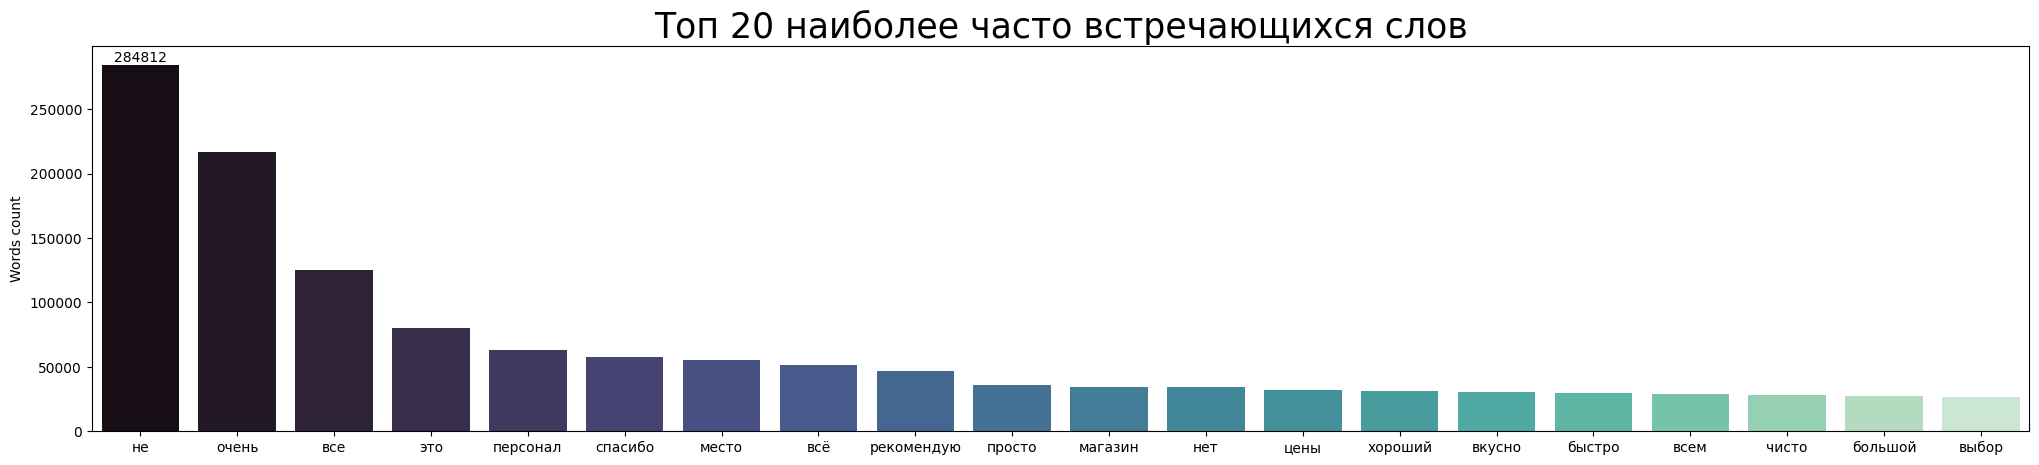

In [ ]:
plt.figure(figsize=(25, 5))
ax = sns.barplot(x=keys, y=values, palette='mako', hue=keys)
plt.title('Топ 20 наиболее часто встречающихся слов', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

In [ ]:
#### Лишнее
positive_importance = pd.DataFrame(
    {'word' : count_idf_positive.get_feature_names_out(),
     'idf' : count_idf_positive.idf_
    }).sort_values(by = 'idf', ascending = False)

negative_importance = pd.DataFrame(
    {'word' : count_idf_negative.get_feature_names_out(),
     'idf' : count_idf_negative.idf_
    }).sort_values(by = 'idf', ascending = False)
negative_importance_frequence = negative_importance.query('word not in @positive_importance.word')[:100]
positive_importance_frequence = positive_importance.query('word not in @negative_importance.word')[:100]
wordcloud_neg = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(negative_importance_frequence.values))
wordcloud_pos = WordCloud(background_color="black",
                               colormap = 'Oranges',
                               max_words=200,
                               mask=None,
                                width=1600,
                               height=1600)\
                        .generate_from_frequencies(dict(positive_importance_frequence.values))

In [ ]:
##### Лишнее
fig, ax = plt.subplots(1, 2, figsize = (20, 12))
ax[0].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title('Топ ' +\
                str(positive_importance_frequence.shape[0]) +\
                ' слов наиболее частотных,\n ' +\
                ' уникальных слов в комментариях\n',
               fontsize = 20)
ax[1].set_title('Топ ' +\
                str(negative_importance_frequence.shape[0]) +\
                ' слов наиболее частотных,\n ' +\
                ' уникальных слов в комментариях\n',
               fontsize = 20)